### 导入相关的库

In [1]:
import os
import json
import torch
import torch.nn.functional as F
import random
import time
from transformers import RobertaTokenizer, RobertaModel
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim
from sklearn.metrics import accuracy_score, f1_score, recall_score,precision_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier as SklearnMLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import numpy as np

### 将模型转移到gpu

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### 导入graphCodeBert模型

In [3]:
# 加载tokenizer和模型
# 加载模型和tokenizer
tokenizer = AutoTokenizer.from_pretrained("../../../model/unixcoder/")
model = AutoModel.from_pretrained("../../../model/unixcoder/").to(device)

### 加载数据样本
基本格式如下：
```json
{
    "title": "JAVA-PY Sample",
    "code": "public class Example { ... }",
    "language": "java",
    "positive": {
        "language_positive": "py",
        "label": "1",
        "code_positive": [
            {"code": "def example(): ..."},
            {"code": "class Example: ..."}
        ]
    },
    "negative": {
        "language_negative": "py",
        "label": "0",
        "code_negative": [
            {"code": "def unrelated(): ..."},
            {"code": "class Unrelated: ..."}
        ]
    }
}

```

In [4]:
# 加载并处理样本数据
def load_samples_from_jsonl(file_path, max_samples=3000):
    samples = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            record = json.loads(line.strip())
            samples.append(record)
            if len(samples) >= max_samples:
                break
    return samples

samples = load_samples_from_jsonl('../../../Datasets/code_pairs_java_python.jsonl')

### 对数据进行编码，先用Tokenizer进行分词，再用GraphCodeBert模型进行编码

In [5]:
# 对样本数据进行编码
def encode_sample(sample, tokenizer, model, device, max_length=512):
    code_inputs = tokenizer(sample['code'], return_tensors='pt', padding='max_length', truncation=True,
                            max_length=max_length).to(device)
    with torch.no_grad():
        code_embedding = model(**code_inputs).last_hidden_state.mean(dim=1).cpu()

    positive_embeddings = []
    for positive_sample in sample['positive']['code_positive']:
        pos_inputs = tokenizer(positive_sample['code'], return_tensors='pt', padding='max_length', truncation=True,
                               max_length=max_length).to(device)
        with torch.no_grad():
            pos_embedding = model(**pos_inputs).last_hidden_state.mean(dim=1).cpu()
        positive_embeddings.append(pos_embedding)

    negative_embeddings = []
    for negative_sample in sample['negative']['code_negative']:
        neg_inputs = tokenizer(negative_sample['code'], return_tensors='pt', padding='max_length', truncation=True,
                               max_length=max_length).to(device)
        with torch.no_grad():
            neg_embedding = model(**neg_inputs).last_hidden_state.mean(dim=1).cpu()
        negative_embeddings.append(neg_embedding)

    return {
        'code_embedding': code_embedding,
        'positive_embeddings': positive_embeddings,
        'negative_embeddings': negative_embeddings
    }

encoded_samples = [encode_sample(sample, tokenizer, model, device) for sample in samples]

In [6]:
# 定义SimCLR对比学习模型和投影头
class ProjectionHead(nn.Module):
    def __init__(self, input_dim):
        super(ProjectionHead, self).__init__()
        self.fc1 = nn.Linear(input_dim, input_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(input_dim, input_dim)

    def forward(self, x):
        x = self.fc1(x)
        self.relu(x)
        self.fc2(x)
        return x

In [7]:
class SimCLR(nn.Module):
    def __init__(self, input_dim=768):
        super(SimCLR, self).__init__()
        self.projection_head = ProjectionHead(input_dim)

    def forward(self, x):
        return self.projection_head(x)

In [8]:
contrastive_model = SimCLR(input_dim=768).to(device)
optimizer = optim.AdamW(contrastive_model.parameters(), lr=3e-4)

In [9]:
# 定义新的对比学习损失函数
def simclr_contrastive_loss(anchor, positives, negatives, temperature=0.2):
    anchor = F.normalize(anchor, dim=1)
    positives = [F.normalize(pos, dim=1) for pos in positives]
    negatives = [F.normalize(neg, dim=1) for neg in negatives]

    positive_loss = 0
    for pos in positives:
        pos_similarity = torch.exp(torch.mm(anchor, pos.t()) / temperature)
        neg_similarity = sum(torch.exp(torch.mm(anchor, neg.t()) / temperature) for neg in negatives)
        positive_loss += -torch.log(pos_similarity / (pos_similarity + neg_similarity)).mean()

    loss = positive_loss / len(positives)
    return loss

In [10]:
# 定义数据集
class CodeCloneDataset(Dataset):
    def __init__(self, samples):
        self.samples = samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        anchor = sample['code_embedding'].view(1, -1)  # 确保 anchor 是二维矩阵
        positives = [pos.view(1, -1) for pos in sample['positive_embeddings']]  # 确保 positives 是二维矩阵
        negatives = [neg.view(1, -1) for neg in sample['negative_embeddings']]  # 确保 negatives 是二维矩阵
        return anchor, positives, negatives

In [11]:
# 训练对比学习模型
def train_contrastive_model(encoded_samples, contrastive_model, epochs=100, temperature=0.2):
    dataset = CodeCloneDataset(encoded_samples)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=True)  # 使用 batch_size=1 确保每次只有一个样本
    contrastive_model.train()
    losses = []
    start_time = time.time()  # 记录训练开始时间
    for epoch in range(epochs):
        total_loss = 0
        for i, (anchor, positives, negatives) in enumerate(dataloader):
            optimizer.zero_grad()
            anchor, positives, negatives = anchor.to(device), [pos.to(device) for pos in positives], [neg.to(device) for neg in negatives]
            anchor = contrastive_model(anchor)
            positives = [contrastive_model(pos) for pos in positives]
            negatives = [contrastive_model(neg) for neg in negatives]
            anchor = anchor.view(anchor.size(0), -1)  # 确保 anchor 是二维矩阵
            positives = [pos.view(pos.size(0), -1) for pos in positives]  # 确保 positives 是二维矩阵
            negatives = [neg.view(neg.size(0), -1) for neg in negatives]  # 确保 negatives 是二维矩阵
            loss = simclr_contrastive_loss(anchor, positives, negatives, temperature)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        losses.append(total_loss / len(dataloader))
        print(f'Epoch {epoch + 1}, Loss: {total_loss / len(dataloader)}')
        torch.cuda.empty_cache()
    end_time = time.time()  # 记录训练结束时间
    training_time = end_time - start_time  # 计算总训练时间
    return losses, training_time

In [12]:
# 定义改进的MLP分类器
class MLPClassifier(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size * 2, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc3 = nn.Linear(hidden_size // 2, 2)  # 二分类
        self.relu = nn.ReLU()
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x1, x2):
        combined = torch.cat((x1, x2), dim=1)
        out = self.fc1(combined)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.log_softmax(out)
        return out

In [13]:
# 训练和评估MLP分类器
def train_and_evaluate_model(model, criterion, optimizer, train_loader, test_data,num_epochs = 100):
    train_losses = []
    start_time = time.time()  # 记录训练开始时间
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        all_preds = []
        all_labels = []
        for (emb1, emb2), label in train_loader:
            emb1, emb2, label = emb1.to(device), emb2.to(device), label.to(device)
            optimizer.zero_grad()
            output = model(emb1, emb2)
            loss = criterion(output, label)
            loss.backward(retain_graph=True)
            optimizer.step()
            total_loss += loss.item()
            preds = torch.argmax(output, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(label.cpu().numpy())

        accuracy = accuracy_score(all_labels, all_preds)
        recall = recall_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds)
        
        #precission
        precision=precision_score(all_labels,all_preds)
        print(
            f'Epoch {epoch + 1}, Loss: {total_loss / len(train_loader):.4f}, Accuracy: {accuracy:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f},Precision:{precision}')
        train_losses.append(total_loss / len(train_loader))

    end_time = time.time()  # 记录训练结束时间
    training_time = end_time - start_time  # 计算总训练时间

    # 在测试集上评估
    model.eval()
    with torch.no_grad():
        emb1_test, emb2_test, labels_test = test_data
        start_time = time.time()  # 记录预测开始时间
        test_output = model(emb1_test, emb2_test)
        end_time = time.time()  # 记录预测结束时间
        prediction_time = end_time - start_time  # 计算预测时间
        test_preds = torch.argmax(test_output, dim=1).cpu().numpy()
        test_labels = labels_test.cpu().numpy()
        test_accuracy = accuracy_score(test_labels, test_preds)
        test_recall = recall_score(test_labels, test_preds)
        test_f1 = f1_score(test_labels, test_preds)
        #test_precision
        test_precision=precision_score(test_labels,test_preds)
        print(f'Test Accuracy: {test_accuracy:.4f}, Test Recall: {test_recall:.4f}, Test F1 Score: {test_f1:.4f},Test Precision:{test_precision}')
    return test_accuracy, test_recall, test_f1,test_precision,train_losses, training_time, prediction_time,

In [14]:
# 获取初始嵌入的评价指标
def evaluate_clones(samples, model, contrastive_model=None, mlp_model=None):
    model.eval()
    if contrastive_model:
        contrastive_model.eval()
    if mlp_model:
        mlp_model.eval()

    all_labels = []
    all_preds = []

    start_time = time.time()  # 记录预测开始时间

    for sample in samples:
        anchor = sample['code_embedding'].squeeze().to(device)  # 确保 anchor 是二维矩阵
        positives = [pos.squeeze().to(device) for pos in sample['positive_embeddings']]  # 确保 positives 是二维矩阵
        negatives = [neg.squeeze().to(device) for neg in sample['negative_embeddings']]  # 确保 negatives 是二维矩阵

        if contrastive_model:
            with torch.no_grad():
                anchor = contrastive_model(anchor)
                positives = [contrastive_model(pos) for pos in positives]
                negatives = [contrastive_model(neg) for neg in negatives]

        if mlp_model:
            with torch.no_grad():
                for pos in positives:
                    output = mlp_model(anchor, pos)
                    all_labels.append(1)
                    all_preds.append(torch.argmax(output).item())
                for neg in negatives:
                    output = mlp_model(anchor, neg)
                    all_labels.append(0)
                    all_preds.append(torch.argmax(output).item())
        else:
            for pos in positives:
                similarity = F.cosine_similarity(anchor, pos, dim=0).item()
                all_labels.append(1)
                all_preds.append(1 if similarity > 0.5 else 0)

            for neg in negatives:
                similarity = F.cosine_similarity(anchor, neg, dim=0).item()
                all_labels.append(0)
                all_preds.append(0 if similarity <= 0.5 else 1)

    end_time = time.time()  # 记录预测结束时间
    prediction_time = end_time - start_time  # 计算预测时间

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    precision=precision_score(all_labels,all_preds)
    return acc, f1, recall,precision, prediction_time

In [15]:
# 将数据集分为训练集和测试集
train_samples, test_samples = train_test_split(encoded_samples, test_size=0.2, random_state=42)

In [16]:
# 初始嵌入的检测结果
initial_acc, initial_f1, initial_recall,initial_precision,initial_prediction_time = evaluate_clones(test_samples, model)
print(f''
      f'Initial Embedding - ACC: {initial_acc}, '
      f'F1: {initial_f1},'
      f' Recall: {initial_recall},'
      f'Precision:{initial_precision}'
    )

Initial Embedding - ACC: 0.6881188118811881, F1: 0.692813228747085, Recall: 0.7034007748600947,Precision:0.6825396825396826


In [17]:
# 对比学习后的嵌入检测结果
contrastive_losses, contrastive_training_time = train_contrastive_model(train_samples, contrastive_model)
contrastive_acc, contrastive_f1, contrastive_recall,contrastive_precision ,contrastive_prediction_time = evaluate_clones(test_samples, model, contrastive_model)
print(
    f'Contrastive Learning Embedding - ACC: {contrastive_acc},'
    f' F1: {contrastive_f1},'
    f' Recall: {contrastive_recall},'
    f'Precision:{contrastive_precision}'
)

Epoch 1, Loss: 1.0434783488878747
Epoch 2, Loss: 0.7255976264192334
Epoch 3, Loss: 0.6451740634138696
Epoch 4, Loss: 0.5906548543592605
Epoch 5, Loss: 0.5596880275321503
Epoch 6, Loss: 0.5245730378276979
Epoch 7, Loss: 0.5059696700893498
Epoch 8, Loss: 0.4875854642906537
Epoch 9, Loss: 0.47038424920251903
Epoch 10, Loss: 0.46169497149511396
Epoch 11, Loss: 0.448406080744074
Epoch 12, Loss: 0.4396963000988277
Epoch 13, Loss: 0.4313204075473671
Epoch 14, Loss: 0.4235074616522373
Epoch 15, Loss: 0.41702038326358887
Epoch 16, Loss: 0.4093056763689189
Epoch 17, Loss: 0.4061820663368174
Epoch 18, Loss: 0.3948284693636621
Epoch 19, Loss: 0.3959051751481214
Epoch 20, Loss: 0.3881239466640788
Epoch 21, Loss: 0.3860822061034075
Epoch 22, Loss: 0.38222962288729223
Epoch 23, Loss: 0.37959449939973033
Epoch 24, Loss: 0.37195508751358525
Epoch 25, Loss: 0.36965683442773295
Epoch 26, Loss: 0.36588961885349514
Epoch 27, Loss: 0.36409769583881524
Epoch 28, Loss: 0.36033576255780647
Epoch 29, Loss: 0.35

In [36]:
# 初始嵌入接MLP的检测结果
mlp_model_initial = MLPClassifier(input_size=768, hidden_size=512).to(device)
mlp_optimizer_initial = optim.AdamW(mlp_model_initial.parameters(), lr=3e-4)
train_pairs_initial, train_labels_initial = [], []
for sample in train_samples:
    anchor = sample['code_embedding'].squeeze()
    for pos in sample['positive_embeddings']:
        train_pairs_initial.append((anchor, pos.squeeze()))
        train_labels_initial.append(1)
    for neg in sample['negative_embeddings']:
        train_pairs_initial.append((anchor, neg.squeeze()))
        train_labels_initial.append(0)
train_loader_initial = DataLoader(list(zip(train_pairs_initial, train_labels_initial)), batch_size=16, shuffle=True)
test_pairs_initial, test_labels_initial = [], []
for sample in test_samples:
    anchor = sample['code_embedding'].squeeze()
    for pos in sample['positive_embeddings']:
        test_pairs_initial.append((anchor, pos.squeeze()))
        test_labels_initial.append(1)
    for neg in sample['negative_embeddings']:
        test_pairs_initial.append((anchor, neg.squeeze()))
        test_labels_initial.append(0)
test_data_initial = (
    torch.stack([pair[0] for pair in test_pairs_initial]).to(device),
    torch.stack([pair[1] for pair in test_pairs_initial]).to(device),
    torch.tensor(test_labels_initial).to(device)
)
initial_mlp_acc, initial_mlp_recall, initial_mlp_f1, initial_mlp_precision,initial_mlp_losses, initial_mlp_training_time, initial_mlp_prediction_time = train_and_evaluate_model(
    mlp_model_initial, nn.CrossEntropyLoss(), mlp_optimizer_initial, train_loader_initial, test_data_initial,50
)
print(
    f'Initial Embedding + MLP - ACC: {initial_mlp_acc},'
    f' F1: {initial_mlp_f1}, '
    f'Recall: {initial_mlp_recall},'
    f'Precision:{initial_mlp_precision}'
)


Epoch 1, Loss: 0.2105, Accuracy: 0.9091, Recall: 0.9283, F1 Score: 0.9108,Precision:0.8940351021583918
Epoch 2, Loss: 0.0692, Accuracy: 0.9740, Recall: 0.9789, F1 Score: 0.9742,Precision:0.9695097437633566
Epoch 3, Loss: 0.0434, Accuracy: 0.9845, Recall: 0.9872, F1 Score: 0.9845,Precision:0.9817718291905673
Epoch 4, Loss: 0.0335, Accuracy: 0.9882, Recall: 0.9901, F1 Score: 0.9882,Precision:0.986399625404393
Epoch 5, Loss: 0.0269, Accuracy: 0.9907, Recall: 0.9921, F1 Score: 0.9907,Precision:0.9893054963783553
Epoch 6, Loss: 0.0225, Accuracy: 0.9921, Recall: 0.9935, F1 Score: 0.9921,Precision:0.9906273298540845
Epoch 7, Loss: 0.0189, Accuracy: 0.9935, Recall: 0.9946, F1 Score: 0.9935,Precision:0.9924116468431599
Epoch 8, Loss: 0.0177, Accuracy: 0.9941, Recall: 0.9951, F1 Score: 0.9941,Precision:0.9932190378710338
Epoch 9, Loss: 0.0151, Accuracy: 0.9950, Recall: 0.9954, F1 Score: 0.9950,Precision:0.9945567485644758
Epoch 10, Loss: 0.0141, Accuracy: 0.9954, Recall: 0.9962, F1 Score: 0.9954

In [35]:
# 对比学习后的嵌入接MLP的检测结果
mlp_model_contrastive = MLPClassifier(input_size=768, hidden_size=512).to(device)
mlp_optimizer_contrastive = optim.AdamW(mlp_model_contrastive.parameters(), lr=3e-5)
train_pairs_contrastive, train_labels_contrastive = [], []
for sample in train_samples:
    anchor = contrastive_model(sample['code_embedding'].squeeze().to(device))
    for pos in sample['positive_embeddings']:
        train_pairs_contrastive.append((anchor, contrastive_model(pos.squeeze().to(device))))
        train_labels_contrastive.append(1)
    for neg in sample['negative_embeddings']:
        train_pairs_contrastive.append((anchor, contrastive_model(neg.squeeze().to(device))))
        train_labels_contrastive.append(0)
train_loader_contrastive = DataLoader(list(zip(train_pairs_contrastive, train_labels_contrastive)), batch_size=16,shuffle=True)
test_pairs_contrastive, test_labels_contrastive = [], []
for sample in test_samples:
    anchor = contrastive_model(sample['code_embedding'].squeeze().to(device))
    for pos in sample['positive_embeddings']:
        test_pairs_contrastive.append((anchor, contrastive_model(pos.squeeze().to(device))))
        test_labels_contrastive.append(1)
    for neg in sample['negative_embeddings']:
        test_pairs_contrastive.append((anchor, contrastive_model(neg.squeeze().to(device))))
        test_labels_contrastive.append(0)
test_data_contrastive = (
    torch.stack([pair[0] for pair in test_pairs_contrastive]).to(device),
    torch.stack([pair[1] for pair in test_pairs_contrastive]).to(device),
    torch.tensor(test_labels_contrastive).to(device)
)
contrastive_mlp_acc, contrastive_mlp_recall, contrastive_mlp_f1,contrastive_mlp_precision, contrastive_mlp_losses, contrastive_mlp_training_time, contrastive_mlp_prediction_time = train_and_evaluate_model(
    mlp_model_contrastive, nn.CrossEntropyLoss(), mlp_optimizer_contrastive, train_loader_contrastive,
    test_data_contrastive,50
)
print(
    f'Contrastive Learning Embedding + MLP - ACC: {contrastive_mlp_acc}, '
    f'F1: {contrastive_mlp_f1},'
    f' Recall: {contrastive_mlp_recall},'
    f'Precision:{contrastive_mlp_precision}'
)

Epoch 1, Loss: 0.0618, Accuracy: 0.9806, Recall: 0.9858, F1 Score: 0.9807,Precision:0.9755406633828722
Epoch 2, Loss: 0.0166, Accuracy: 0.9947, Recall: 0.9955, F1 Score: 0.9947,Precision:0.9938363760450435
Epoch 3, Loss: 0.0123, Accuracy: 0.9960, Recall: 0.9966, F1 Score: 0.9960,Precision:0.995454933424377
Epoch 4, Loss: 0.0093, Accuracy: 0.9970, Recall: 0.9974, F1 Score: 0.9970,Precision:0.9965847723537322
Epoch 5, Loss: 0.0078, Accuracy: 0.9976, Recall: 0.9978, F1 Score: 0.9976,Precision:0.9974160758520543
Epoch 6, Loss: 0.0069, Accuracy: 0.9978, Recall: 0.9979, F1 Score: 0.9978,Precision:0.9976294208098411
Epoch 7, Loss: 0.0060, Accuracy: 0.9981, Recall: 0.9984, F1 Score: 0.9981,Precision:0.9978861059509321
Epoch 8, Loss: 0.0051, Accuracy: 0.9982, Recall: 0.9984, F1 Score: 0.9982,Precision:0.9980353215025519
Epoch 9, Loss: 0.0051, Accuracy: 0.9983, Recall: 0.9985, F1 Score: 0.9983,Precision:0.9981420578311194
Epoch 10, Loss: 0.0043, Accuracy: 0.9987, Recall: 0.9988, F1 Score: 0.9987

In [20]:
# 其他分类器的对比实验
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVM': SVC(),
    'Random Forest': RandomForestClassifier(),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Extra Tree': ExtraTreeClassifier(),
    'Gaussian NB': GaussianNB(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'AdaBoost': AdaBoostClassifier(),
}

In [21]:
def evaluate_classifiers(train_samples, test_samples, classifiers, contrastive_model):
    X_train, y_train, X_test, y_test = [], [], [], []

    for sample in train_samples:
        anchor = contrastive_model(sample['code_embedding'].view(-1).to(device)).cpu().detach().numpy().flatten()
        for pos in sample['positive_embeddings']:
            X_train.append(anchor + contrastive_model(pos.view(-1).to(device)).cpu().detach().numpy().flatten())
            y_train.append(1)
        for neg in sample['negative_embeddings']:
            X_train.append(anchor + contrastive_model(neg.view(-1).to(device)).cpu().detach().numpy().flatten())
            y_train.append(0)

    for sample in test_samples:
        anchor = contrastive_model(sample['code_embedding'].view(-1).to(device)).cpu().detach().numpy().flatten()
        for pos in sample['positive_embeddings']:
            X_test.append(anchor + contrastive_model(pos.view(-1).to(device)).cpu().detach().numpy().flatten())
            y_test.append(1)
        for neg in sample['negative_embeddings']:
            X_test.append(anchor + contrastive_model(neg.view(-1).to(device)).cpu().detach().numpy().flatten())
            y_test.append(0)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    results = {}
    training_times = {}
    prediction_times = {}

    for name, clf in classifiers.items():
        start_time = time.time()  # 记录训练开始时间
        clf.fit(X_train, y_train)
        end_time = time.time()  # 记录训练结束时间
        training_time = end_time - start_time  # 计算训练时间
        training_times[name] = training_time

        start_time = time.time()  # 记录预测开始时间
        y_pred = clf.predict(X_test)
        end_time = time.time()  # 记录预测结束时间
        prediction_time = end_time - start_time  # 计算预测时间
        prediction_times[name] = prediction_time

        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        precision=precision_score(y_test,y_pred)
        results[name] = (acc, f1, recall,precision)

    return results, training_times, prediction_times

In [22]:
# 分类器对比结果
classifier_results, classifier_training_times, classifier_prediction_times = evaluate_classifiers(train_samples, test_samples, classifiers, contrastive_model)

f:\Ana\11\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


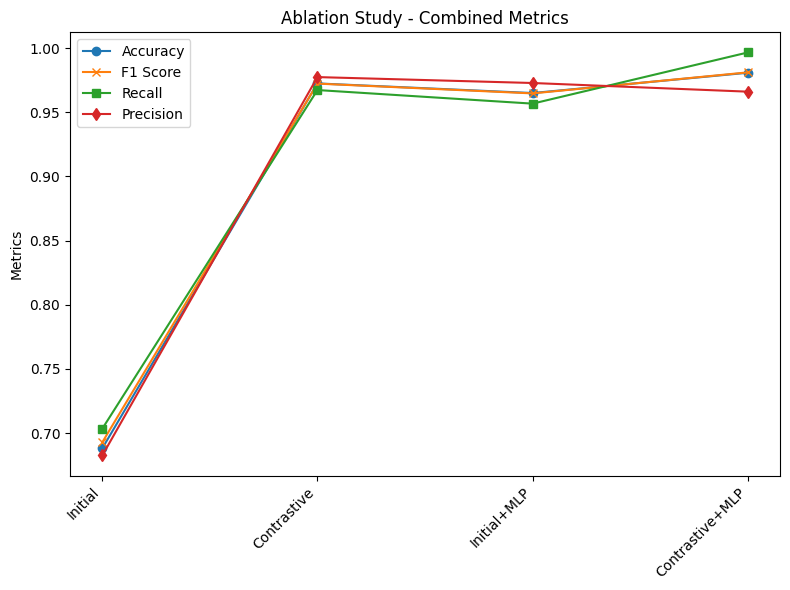

In [23]:
plt.style.use('default')
# 绘制消融实验结果
labels_ablation = ['Initial', 'Contrastive', 'Initial+MLP', 'Contrastive+MLP']
# acc
acc_values_ablation = [initial_acc, contrastive_acc, initial_mlp_acc, contrastive_mlp_acc]
#f1分数
f1_values_ablation = [initial_f1, contrastive_f1, initial_mlp_f1, contrastive_mlp_f1]
#召回率
recall_values_ablation = [initial_recall, contrastive_recall, initial_mlp_recall, contrastive_mlp_recall]
#准确率
precision_values_ablation=[initial_precision,contrastive_precision,initial_mlp_precision,contrastive_mlp_precision]
x_ablation = range(len(labels_ablation))

# #ACC单独制图
# plt.figure(figsize=(8, 6))
# plt.plot(x_ablation, acc_values_ablation, label='Accuracy', marker='o')
# plt.xticks(x_ablation, labels_ablation, rotation=45, ha='right')
# plt.ylabel('Accuracy')
# plt.title('Ablation Study - Accuracy')
# plt.tight_layout()
# plt.savefig(time.time().__str__()+"Ablation Study - Accuracy"+".png")
# plt.show()

# #F1分数单独制图
# plt.figure(figsize=(8, 6))
# plt.plot(x_ablation, f1_values_ablation, label='F1 Score', marker='o')
# plt.xticks(x_ablation, labels_ablation, rotation=45, ha='right')
# plt.ylabel('F1 Score')
# plt.title('Ablation Study - F1 Score')
# plt.tight_layout()
# plt.savefig(time.time().__str__()+"Ablation Study - F1 Score"+".png")
# plt.show()

# # 召回率单独制图
# plt.figure(figsize=(8, 6))
# plt.plot(x_ablation, recall_values_ablation, label='Recall', marker='o')
# plt.xticks(x_ablation, labels_ablation, rotation=45, ha='right')
# plt.xlabel('Ablation Study')
# plt.ylabel('Recall')
# plt.title('Ablation Study - Recall')
# plt.tight_layout()
# plt.savefig(time.time().__str__()+"Ablation Study - Recall"+".png")
# plt.show()

# # precision单独制图
# plt.figure(figsize=(8, 6))
# plt.plot(x_ablation,precision_values_ablation, label='Precision', marker='o')
# plt.xticks(x_ablation, labels_ablation, rotation=45, ha='right')
# plt.xlabel('Ablation Study')
# plt.ylabel('Precision')
# plt.title('Ablation Study - Precision')
# plt.tight_layout()
# plt.savefig(time.time().__str__()+"Ablation Study - Precision"+".png")
# plt.show()



# 合并指标的消融实验图
plt.figure(figsize=(8, 6))
plt.plot(x_ablation, acc_values_ablation, label='Accuracy', marker='o')
plt.plot(x_ablation, f1_values_ablation, label='F1 Score', marker='x')
plt.plot(x_ablation, recall_values_ablation, label='Recall', marker='s')
plt.plot(x_ablation, precision_values_ablation, label='Precision', marker='d')
plt.xticks(x_ablation, labels_ablation, rotation=45, ha='right')
plt.ylabel('Metrics')
plt.title('Ablation Study - Combined Metrics')
plt.legend()
plt.tight_layout()
plt.savefig(time.time().__str__()+'Ablation Study - Combined Metrics'+".png")
plt.show()

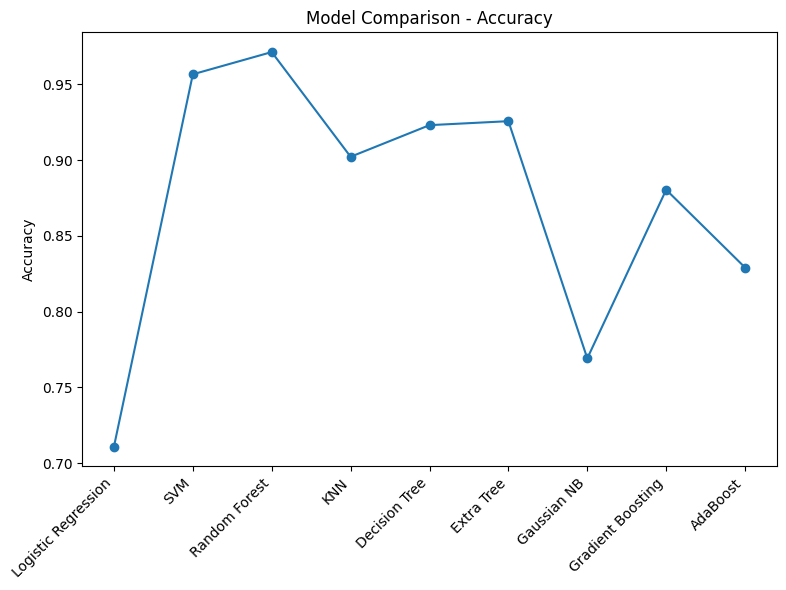

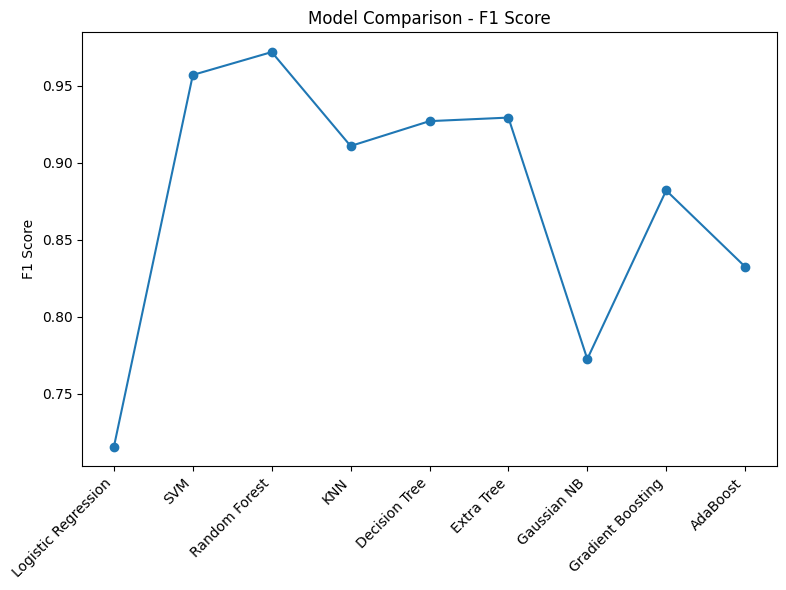

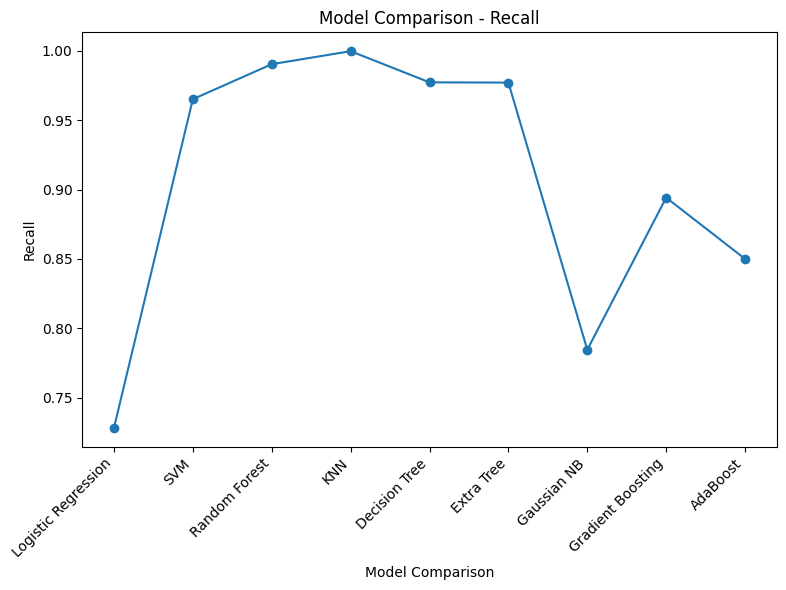

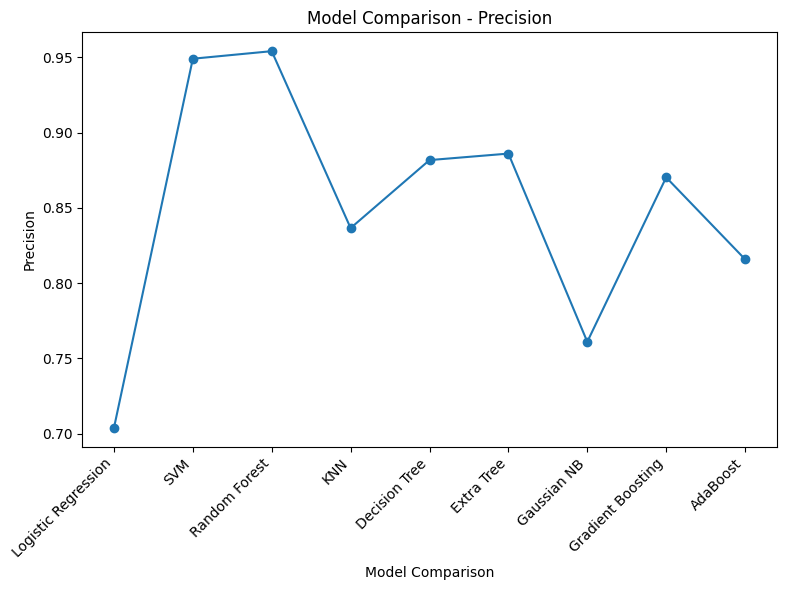

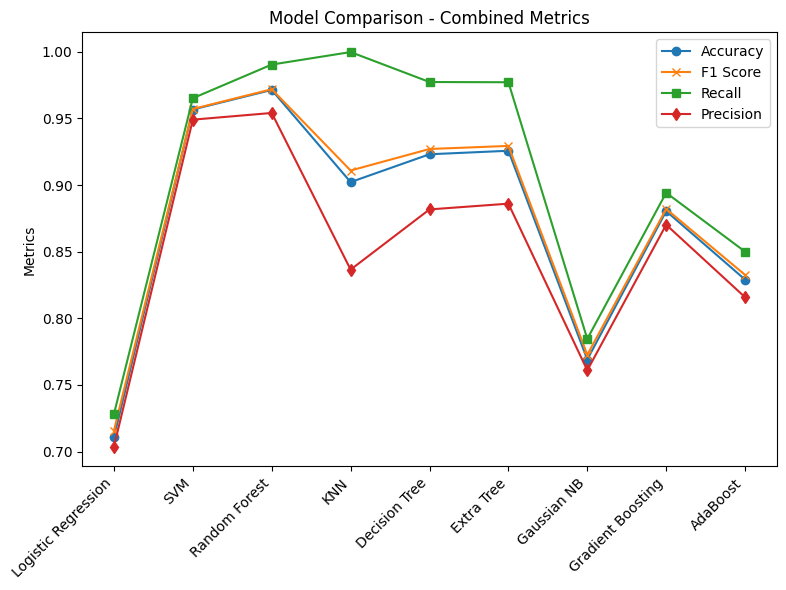

In [24]:
# 绘制模型对比实验结果
labels_model_comparison = list(classifier_results.keys())
acc_values_model_comparison = [result[0] for result in classifier_results.values()]
f1_values_model_comparison = [result[1] for result in classifier_results.values()]
recall_values_model_comparison = [result[2] for result in classifier_results.values()]
precision_values_model_comparison = [result[3] for result in classifier_results.values()]


x_model_comparison = range(len(labels_model_comparison))

plt.figure(figsize=(8, 6))
plt.plot(x_model_comparison, acc_values_model_comparison, label='Accuracy', marker='o')
plt.xticks(x_model_comparison, labels_model_comparison, rotation=45, ha='right')
plt.ylabel('Accuracy')
plt.title('Model Comparison - Accuracy')
plt.tight_layout()
plt.savefig(time.time().__str__()+'Model Comparison - Accuracy'+".png")
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(x_model_comparison, f1_values_model_comparison, label='F1 Score', marker='o')
plt.xticks(x_model_comparison, labels_model_comparison, rotation=45, ha='right')
plt.ylabel('F1 Score')
plt.title('Model Comparison - F1 Score')
plt.tight_layout()
plt.savefig(time.time().__str__()+'Model Comparison - F1 Score'+".png")
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(x_model_comparison, recall_values_model_comparison, label='Recall', marker='o')
plt.xticks(x_model_comparison, labels_model_comparison, rotation=45, ha='right')
plt.xlabel('Model Comparison')
plt.ylabel('Recall')
plt.title('Model Comparison - Recall')
plt.tight_layout()
plt.savefig(time.time().__str__()+'Model Comparison - Recall'+".png")
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(x_model_comparison,precision_values_model_comparison, label='Precision', marker='o')
plt.xticks(x_model_comparison, labels_model_comparison, rotation=45, ha='right')
plt.xlabel('Model Comparison')
plt.ylabel('Precision')
plt.title('Model Comparison - Precision')
plt.tight_layout()
plt.savefig(time.time().__str__()+'Model Comparison - Precision'+".png")
plt.show()



# 合并指标的模型对比实验图
plt.figure(figsize=(8, 6))
plt.plot(x_model_comparison, acc_values_model_comparison, label='Accuracy', marker='o')
plt.plot(x_model_comparison, f1_values_model_comparison, label='F1 Score', marker='x')
plt.plot(x_model_comparison, recall_values_model_comparison, label='Recall', marker='s')
plt.plot(x_model_comparison, precision_values_model_comparison, label='Precision', marker='d')
plt.xticks(x_model_comparison, labels_model_comparison, rotation=45, ha='right')
plt.ylabel('Metrics')
plt.title('Model Comparison - Combined Metrics')
plt.legend()
plt.tight_layout()
plt.savefig(time.time().__str__()+'Model Comparison - Combined Metrics'+".png")
plt.show()

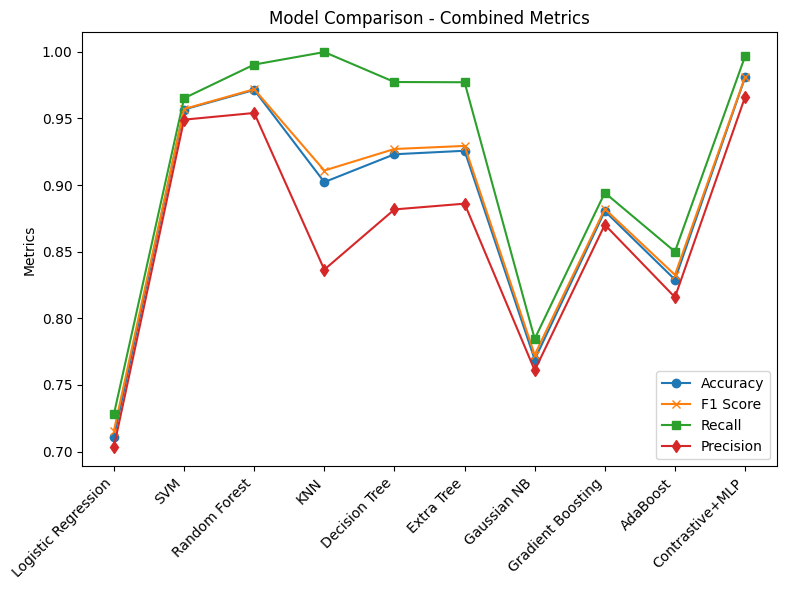

In [25]:
# 绘制综合模型对比实验结果
labels_model_comparison.append("Contrastive+MLP")
acc_values_model_comparison.append(contrastive_mlp_acc)
f1_values_model_comparison.append(contrastive_mlp_f1)
recall_values_model_comparison.append(contrastive_mlp_recall)
precision_values_model_comparison.append(contrastive_mlp_precision)

x_model_comparison = range(len(labels_model_comparison))

# 合并指标的模型对比实验图
plt.figure(figsize=(8, 6))
plt.plot(x_model_comparison, acc_values_model_comparison, label='Accuracy', marker='o')
plt.plot(x_model_comparison, f1_values_model_comparison, label='F1 Score', marker='x')
plt.plot(x_model_comparison, recall_values_model_comparison, label='Recall', marker='s')
plt.plot(x_model_comparison, precision_values_model_comparison, label='Precision', marker='d')
plt.xticks(x_model_comparison, labels_model_comparison, rotation=45, ha='right')
plt.ylabel('Metrics')
plt.title('Model Comparison - Combined Metrics')
plt.legend()
plt.tight_layout()
plt.savefig(time.time().__str__()+'Model Comparison - Combined Metrics'+".png")
plt.show()

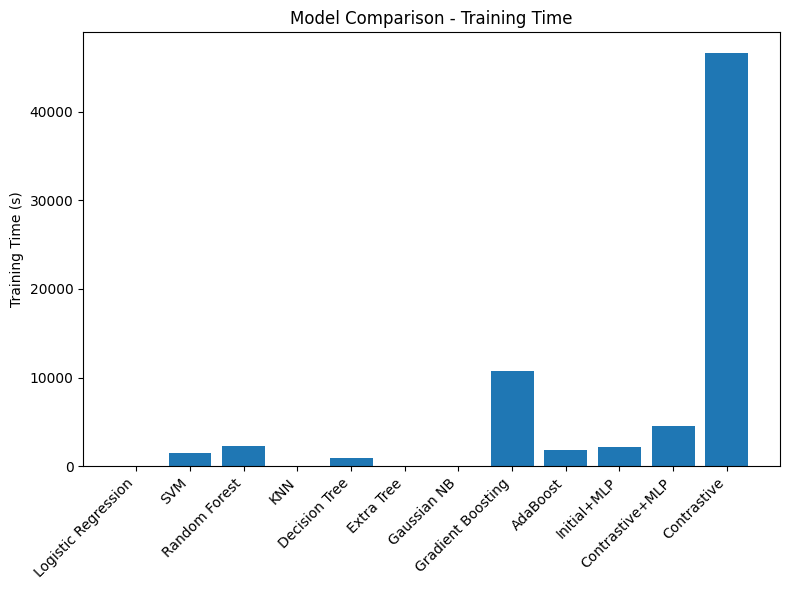

In [26]:
# 绘制训练时间对比图
training_times_model_comparison = list(classifier_training_times.values())
training_times_model_comparison.append(initial_mlp_training_time)
training_times_model_comparison.append(contrastive_mlp_training_time)
training_times_model_comparison.append(contrastive_training_time)

labels_training_time_comparison = list(classifier_training_times.keys())
labels_training_time_comparison.extend(['Initial+MLP', 'Contrastive+MLP', 'Contrastive'])

x_training_time_comparison = range(len(labels_training_time_comparison))

plt.figure(figsize=(8, 6))
plt.bar(x_training_time_comparison, training_times_model_comparison, tick_label=labels_training_time_comparison)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Training Time (s)')
plt.title('Model Comparison - Training Time')
plt.tight_layout()
plt.savefig(time.time().__str__()+'Model Comparison - Training Time'+".png")
plt.show()

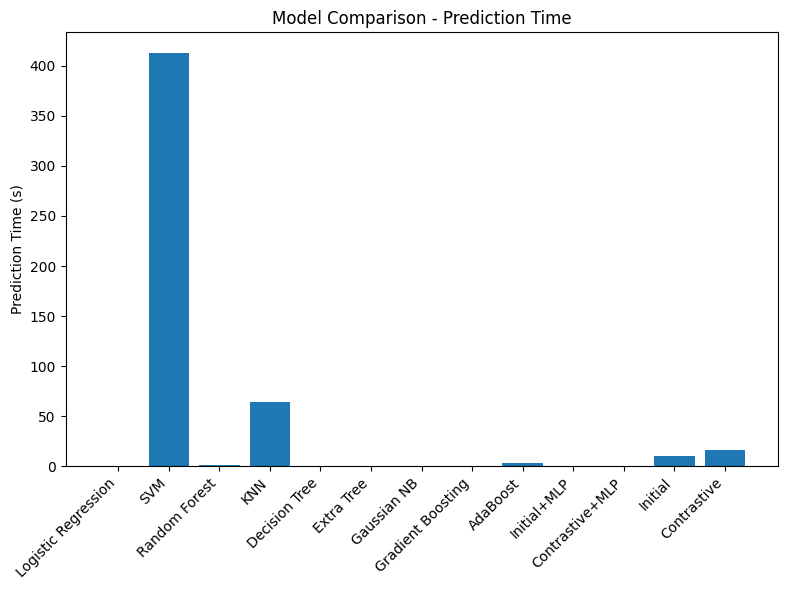

In [27]:
# 绘制预测时间对比图
prediction_times_model_comparison = list(classifier_prediction_times.values())
prediction_times_model_comparison.append(initial_mlp_prediction_time)
prediction_times_model_comparison.append(contrastive_mlp_prediction_time)
prediction_times_model_comparison.append(initial_prediction_time)
prediction_times_model_comparison.append(contrastive_prediction_time)

labels_prediction_time_comparison = list(classifier_prediction_times.keys())
labels_prediction_time_comparison.extend(['Initial+MLP', 'Contrastive+MLP', 'Initial', 'Contrastive'])

x_prediction_time_comparison = range(len(labels_prediction_time_comparison))

plt.figure(figsize=(8, 6))
plt.bar(x_prediction_time_comparison, prediction_times_model_comparison, tick_label=labels_prediction_time_comparison)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Prediction Time (s)')
plt.title('Model Comparison - Prediction Time')
plt.tight_layout()
plt.savefig(time.time().__str__()+'Model Comparison - Prediction Time'+".png")
plt.show()

### 对比学习收敛图

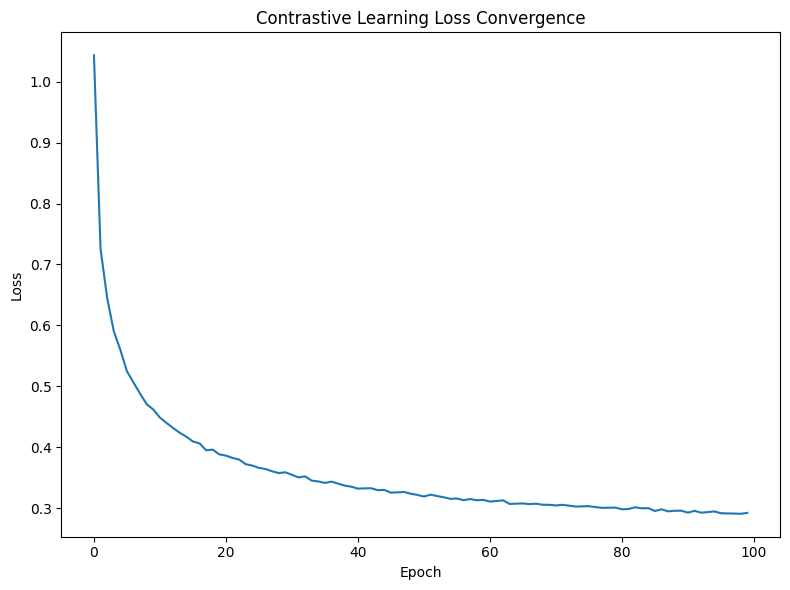

In [28]:
# 绘制对比学习的收敛图
plt.figure(figsize=(8, 6))
plt.plot(contrastive_losses, label='Contrastive Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Contrastive Learning Loss Convergence')
plt.tight_layout()
plt.savefig(time.time().__str__()+'Contrastive Learning Loss Convergence'+".png")
plt.show()

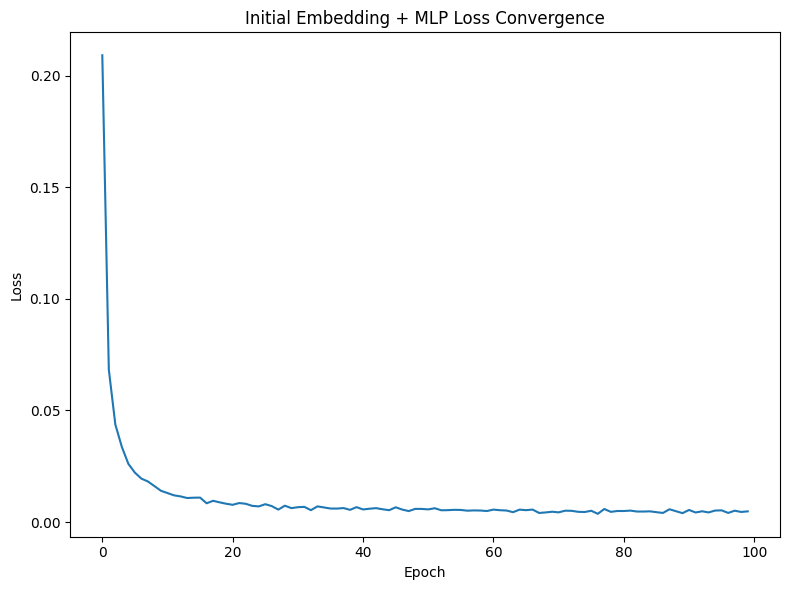

In [29]:
# 绘制在初始嵌入上MLP的收敛图
plt.figure(figsize=(8, 6))
plt.plot(initial_mlp_losses, label='Initial Embedding + MLP Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Initial Embedding + MLP Loss Convergence')
plt.tight_layout()
plt.savefig(time.time().__str__()+'Initial Embedding + MLP Loss Convergence'+".png")
plt.show()


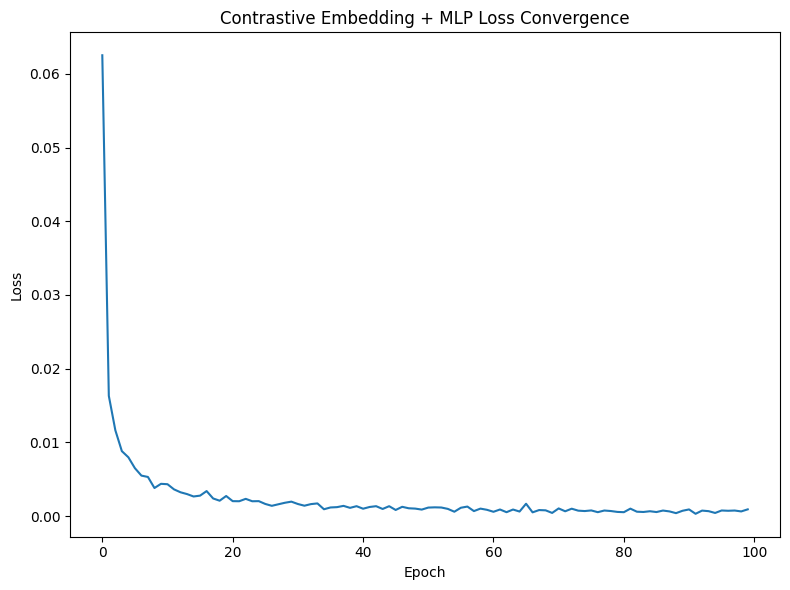

In [30]:
# 绘制在对比学习嵌入上MLP的收敛图
plt.figure(figsize=(8, 6))
plt.plot(contrastive_mlp_losses, label='Contrastive Embedding + MLP Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Contrastive Embedding + MLP Loss Convergence')
plt.tight_layout()
plt.savefig(time.time().__str__()+'Contrastive Embedding + MLP Loss Convergence'+".png")
plt.show()

In [31]:
# 绘制T-SNE图
def plot_tsne(samples, contrastive_model=None, title=''):
    embeddings = []
    labels = []
    cnt=0
    for sample in samples:
        anchor = sample['code_embedding'].squeeze().numpy()
        embeddings.append(anchor)
        labels.append('anchor')
        for pos in sample['positive_embeddings']:
            embeddings.append(pos.squeeze().numpy())
            labels.append('positive')
        for neg in sample['negative_embeddings']:
            embeddings.append(neg.squeeze().numpy())
            labels.append('negative')
        cnt+=1
        if cnt==2:
            break
    if contrastive_model:
        contrastive_model.eval()
        embeddings = contrastive_model(torch.tensor(embeddings).to(device)).cpu().detach().numpy()

    embeddings = np.array(embeddings)  # 确保 embeddings 是 NumPy 数组

    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(embeddings)

    plt.figure(figsize=(8, 6))
    for label in ['anchor', 'positive', 'negative']:
        idx = [i for i, lbl in enumerate(labels) if lbl == label]
        plt.scatter(tsne_results[idx, 0], tsne_results[idx, 1], label=label)
    plt.legend()
    plt.title(title)
    plt.savefig(time.time().__str__()+title+".png")
    plt.show()

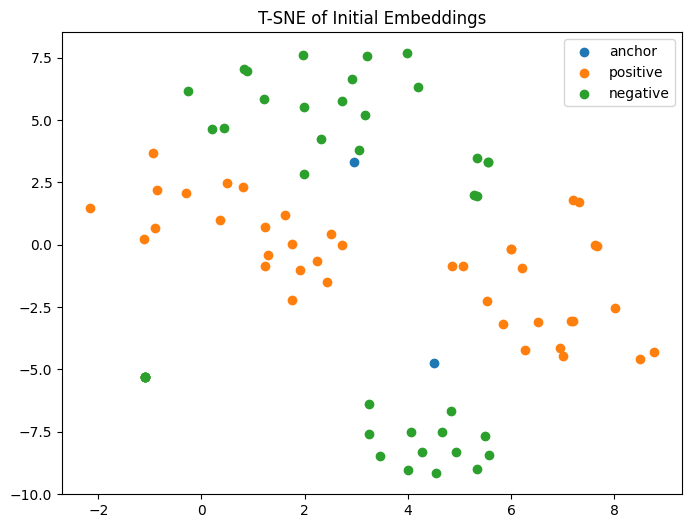

C:\Users\zengyou\AppData\Local\Temp\ipykernel_39268\332798698.py:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:248.)
  embeddings = contrastive_model(torch.tensor(embeddings).to(device)).cpu().detach().numpy()


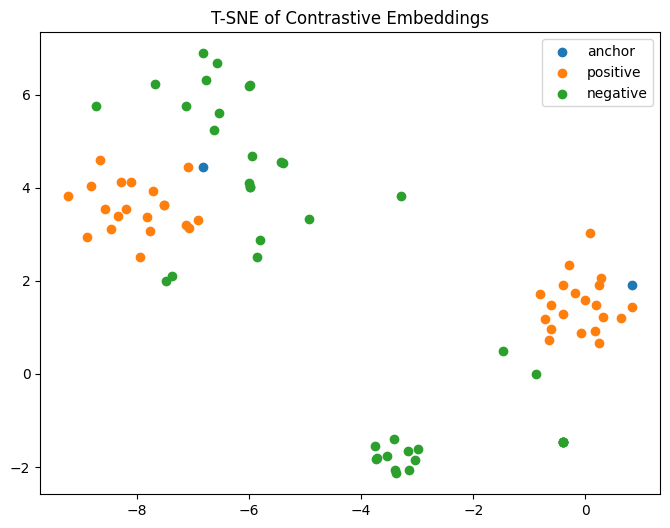

In [32]:
# 绘制T-SNE图：对比学习前后的嵌入分布
plot_tsne(test_samples, title='T-SNE of Initial Embeddings')
plot_tsne(test_samples, contrastive_model, title='T-SNE of Contrastive Embeddings')

In [33]:
# 打印所有实验结果
print("Ablation Study Results:")
print(f"Initial Embedding - ACC: {initial_acc}, F1: {initial_f1}, Recall: {initial_recall}, Precision: {initial_precision}, Prediction Time: {initial_prediction_time:.4f}s")
print(f"Contrastive Learning Embedding - ACC: {contrastive_acc}, F1: {contrastive_f1}, Recall: {contrastive_recall}, Precision: {contrastive_precision}, Training Time: {contrastive_training_time:.4f}s, Prediction Time: {contrastive_prediction_time:.4f}s")
print(f"Initial Embedding + MLP - ACC: {initial_mlp_acc}, F1: {initial_mlp_f1}, Recall: {initial_mlp_recall}, Precision: {initial_mlp_precision}, Training Time: {initial_mlp_training_time:.4f}s, Prediction Time: {initial_mlp_prediction_time:.4f}s")
print(f"Contrastive Learning Embedding + MLP - ACC: {contrastive_mlp_acc}, F1: {contrastive_mlp_f1}, Recall: {contrastive_mlp_recall}, Precision: {contrastive_mlp_precision}, Training Time: {contrastive_mlp_training_time:.4f}s, Prediction Time: {contrastive_mlp_prediction_time:.4f}s")

print("\nModel Comparison Results:")
for name, result in classifier_results.items():
    print(f"{name} - ACC: {result[0]}, F1: {result[1]}, Recall: {result[2]}, Precision: {result[3]}, Training Time: {classifier_training_times[name]:.4f}s, Prediction Time: {classifier_prediction_times[name]:.4f}s")

Ablation Study Results:
Initial Embedding - ACC: 0.6881188118811881, F1: 0.692813228747085, Recall: 0.7034007748600947, Precision: 0.6825396825396826, Prediction Time: 10.2631s
Contrastive Learning Embedding - ACC: 0.972449418854929, F1: 0.9723063608827348, Recall: 0.9672836848902282, Precision: 0.9773814702044367, Training Time: 46613.8742s, Prediction Time: 16.0620s
Initial Embedding + MLP - ACC: 0.9649591046061128, F1: 0.9646670717944267, Recall: 0.9566939302625915, Precision: 0.9727742274358749, Training Time: 2205.2224s, Prediction Time: 0.0170s
Contrastive Learning Embedding + MLP - ACC: 0.9807576409814894, F1: 0.9810569140144935, Recall: 0.9965561773568661, Precision: 0.9660323819061927, Training Time: 4570.1902s, Prediction Time: 0.0080s

Model Comparison Results:
Logistic Regression - ACC: 0.7108480413258718, F1: 0.7157787839038633, Recall: 0.7281962978906587, Precision: 0.7037776668330837, Training Time: 73.4655s, Prediction Time: 0.0340s
SVM - ACC: 0.9566508824795523, F1: 0.